In [ ]:
# Overview
Creating nice 3d renderings and interactive graphics from the data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import os
from skimage.io import imread
import numpy as np

In [2]:
all_images = glob(os.path.join('..', 'data', '*.tif'))
img_df = pd.DataFrame([dict(path = c_file) for c_file in all_images])
img_df['basename'] = img_df['path'].map(lambda x: os.path.basename(x).split('.')[0])
img_df['frame_id'] = img_df['basename'].map(lambda x: '_'.join(x.split('_')[0:-1]))
img_df['sample'] = img_df['basename'].map(lambda x: x.split('_')[0])
img_df['slice'] = img_df['basename'].map(lambda x: int(x.split('_')[3]))
img_df['frame'] = img_df['basename'].map(lambda x: int(x.split('_')[1]))
# group by prefix
img_3d_df = img_df.sort_values(['sample', 'frame_id', 'slice']).groupby(['sample', 'frame', 'frame_id'])['path'].apply(list).reset_index()
img_3d_df

,sample,frame,frame_id,path
0,MI5,0,MI5_0_00,"[../data/MI5_0_00_1500.rec.8bit.tif, ../data/M..."
1,MI5,1,MI5_1_00,"[../data/MI5_1_00_1500.rec.8bit.tif, ../data/M..."
2,MI5,1,MI5_1_01,"[../data/MI5_1_01_1500.rec.8bit.tif, ../data/M..."
3,MI5,1,MI5_1_02,"[../data/MI5_1_02_1500.rec.8bit.tif, ../data/M..."
4,MI7,0,MI7_0_00,"[../data/MI7_0_00_1300.rec.8bit.tif, ../data/M..."
5,MI7,1,MI7_1_00,"[../data/MI7_1_00_1300.rec.8bit.tif, ../data/M..."
6,MI7,1,MI7_1_01,"[../data/MI7_1_01_1300.rec.8bit.tif, ../data/M..."
7,MI7,1,MI7_1_02,"[../data/MI7_1_02_1300.rec.8bit.tif, ../data/M..."


In [18]:
from skimage.filters import threshold_minimum
from skimage.morphology.convex_hull import convex_hull_image
from skimage.morphology import binary_closing, binary_opening, disk, label
from skimage.measure import regionprops

from skimage.color import label2rgb
from scipy import ndimage as ndi

def threshold_slice_2d(raw_slice):
    in_slice = ndi.median_filter(raw_slice, [7, 7])
    # basic threshold
    thresh_min = threshold_minimum(in_slice)
    # make solid component
    solid_part = binary_closing(in_slice>thresh_min, disk(4))
    solid_part = ndi.binary_fill_holes(solid_part)
    # calculate porous component inside solid
    porous_part = (in_slice < thresh_min)*solid_part
    #porous_part = binary_opening(porous_part, disk(2))
    porous_part = binary_closing(porous_part, disk(2))
    # create label by combining
    label_slice = solid_part.astype(np.uint8).clip(0,1)
    label_slice += (porous_part).astype(np.uint8).clip(0,1)
    return label_slice, thresh_min

def paths_to_vol(in_paths):
    return np.stack([threshold_slice_2d(imread(x))[0] for x in in_paths],-1)

In [19]:
img_3d_df['volume'] = img_3d_df['path'].map(paths_to_vol)

In [20]:
import ipywidgets as ipw
import ipyvolume.pylab as p3
from skimage.measure import marching_cubes_lewiner
from skimage.morphology import label, binary_opening, ball

# Show Surface Rendering

# MI5

In [124]:
c_query = img_3d_df.query('sample == "MI5"').sort_values(['frame_id'])
n_iter = c_query.iterrows()

fig = p3.figure()
s = None

def set_view(figure, framenr, fraction):
    global s
    _, c_row = next(n_iter)
    v,f, _, _ = marching_cubes_lewiner(c_row['volume']==2)
    if s is not None:
        s.visible = False
    s = p3.plot_trisurf(v[:,0], v[:,1], v[:,2], triangles = f, color='orange')
    p3.zlim(-250, 250) # so aspect ratio looks right
    p3.xlim(300, 900)
    p3.ylim(300, 900)
p3.style.use('dark')
p3.show()
p3.movie('mi5_surface.gif', set_view, fps=1, frames=len(c_query))

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], style={'axes': {'visible': True, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': True}, 'background-color': 'black'}, tf=None, width=400, xlim=[0.0, 1.0], ylim=[0.0, 1.0], zlim=[0.0, 1.0]),))

Output()

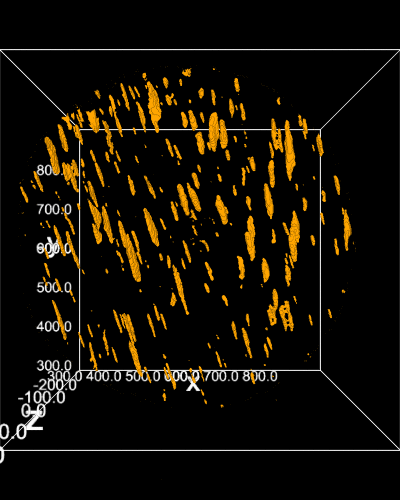

In [126]:
from IPython.display import Image
Image('mi5_surface.gif')

# MI7

In [128]:
c_query = img_3d_df.query('sample == "MI7"').sort_values(['frame_id'])
n_iter = c_query.iterrows()

fig = p3.figure()
s = None

def set_view(figure, framenr, fraction):
    global s
    _, c_row = next(n_iter)
    v,f, _, _ = marching_cubes_lewiner(c_row['volume']==2)
    if s is not None:
        s.visible = False
    s = p3.plot_trisurf(v[:,0], v[:,1], v[:,2], triangles = f, color='orange')
    p3.zlim(-250, 250) # so aspect ratio looks right
    p3.xlim(300, 900)
    p3.ylim(300, 900)
p3.style.use('dark')
p3.show()
p3.movie('mi7_surface.gif', set_view, fps=1, frames=len(c_query))

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], style={'axes': {'visible': True, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': True}, 'background-color': 'black'}, tf=None, width=400, xlim=[0.0, 1.0], ylim=[0.0, 1.0], zlim=[0.0, 1.0]),))

Output()

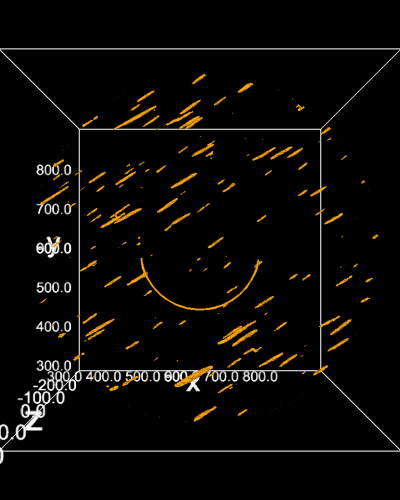

In [129]:
from IPython.display import Image
Image('mi7_surface.gif')

# Point-based Views

In [60]:
from skimage.measure import regionprops
from sklearn.decomposition import PCA
from keras.preprocessing.sequence import pad_sequences as pseq
pad_sequences = lambda x: pseq(x, dtype = np.float32)

def get_orientation(c_reg):
    n_vm = PCA()
    n_vm.fit(c_reg.coords)
    return n_vm.components_[:,0]

def row_to_dr(c_row):
    lab_vol = label(binary_opening(c_row['volume']==2, ball(2)))
    n_props = regionprops(lab_vol)
    v = np.stack([c_reg.centroid for c_reg in n_props],0)
    dr = np.stack([get_orientation(c_reg) for c_reg in n_props],0)
    return v, dr

def df_to_quiver(cur_df):
    x_list, y_list, z_list, u_list, v_list, w_list = [], [], [], [], [], []
    for _, c_row in cur_df.iterrows():
        v, dr = row_to_dr(c_row)
        x_list += [v[:,0]]
        y_list += [v[:,1]]
        z_list += [v[:,2]]
        u_list += [dr[:,0]]
        v_list += [dr[:,1]]
        w_list += [dr[:,2]]
    return x_list, y_list, z_list, u_list, v_list, w_list


# MI5

In [130]:
x_list, y_list, z_list, u_list, v_list, w_list = df_to_quiver(img_3d_df.query('sample == "MI5"'))
fig = p3.figure()
s = p3.quiver(pad_sequences(x_list), pad_sequences(y_list), pad_sequences(z_list), 
              pad_sequences(u_list), pad_sequences(v_list), pad_sequences(w_list),
              size_selected = 5*(pad_sequences(x_list)>0),
                    color='red', marker = 'arrow')
p3.style.use('dark')
p3.zlim(-250, 250) # so aspect ratio looks right
p3.animation_control(s, interval = 1000) # shows controls for animation controls
p3.show()

VBox(children=(Figure(animation_exponent=1.0, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scatters=[Scatter(color_selected=array('white', dtype='<U5'), geo='arrow', size=array(20), size_selected=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]]), vx=array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.       

# MI7

In [131]:
x_list, y_list, z_list, u_list, v_list, w_list = df_to_quiver(img_3d_df.query('sample == "MI7"'))
fig = p3.figure()
s = p3.quiver(pad_sequences(x_list), pad_sequences(y_list), pad_sequences(z_list), 
              pad_sequences(u_list), pad_sequences(v_list), pad_sequences(w_list),
              size_selected = 5*(pad_sequences(x_list)>0),
                    color='red', marker = 'arrow')
p3.style.use('dark')
p3.zlim(-250, 250) # so aspect ratio looks right
p3.animation_control(s, interval = 1000) # shows controls for animation controls
p3.show()

VBox(children=(Figure(animation_exponent=1.0, camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scatters=[Scatter(color_selected=array('white', dtype='<U5'), geo='arrow', size=array(20), size_selected=array([[0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5]]), vx=array([[ 0.        ,  0.        ,  0.        , ..., -1.        ,
         0.71388817, -0.3920362 ],
       [ 0.        ,  0.        ,  0.        , ..., -0.64263856,
         0.42764106, -0.30065772],
       [ 0.07285408, -0.8194362 ,  0.5341259 , ..., -0.2914893 ,
         0.15417044, -0.23570226],
       [ 0.        ,  0.        ,  0.        , ...,  0.70710677,
        -0.        , -0.01315653]], dtype=float32), vy=array([[ 0.        ,  0.        ,  0.        , ..., -0.        ,
         0.70025975, -0.36476094],
       [ 0.        ,  0.        ,  0.        , ...,  0.7661695 ,
         0.8312271 , -0.95373213],
       [-0.9547109 ,  0.5731599 , -0.5099269 , ...,  0.43374115,
        -0.98800564,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.70710677,
        -0.        ,  0.998029  ]], dtype=float32), vz=array([[ 0.        ,  0.        ,  0.        , ..., -0.        ,
        -0.        , -0.8445455 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.35522464, -0.        ],
       [-0.28847763,  0.00348209, -0.67430264, ..., -0.85258585,
         0.00873855, -0.9718253 ],
       [ 0.        ,  0.        ,  0.        , ..., -0.        ,
        -1.        ,  0.06135951]], dtype=float32), x=array([[   0.     ,    0.     ,    0.     , ...,  598.5    ,  693.3077 ,
         713.39215],
       [   0.     ,    0.     ,    0.     , ...,  695.26715,  817.6194 ,
         825.3472 ],
       [ 199.03918,  227.44191,  209.22516, ..., 1064.4673 , 1072.7172 ,
        1074.5    ],
       [   0.     ,    0.     ,    0.     , ..., 1119.3508 , 1128.     ,
        1133.2919 ]], dtype=float32), y=array([[  0.     ,   0.     ,   0.     , ..., 937.     , 924.95605,
        570.35297],
       [  0.     ,   0.     ,   0.     , ..., 678.5191 , 421.8129 ,
        408.41666],
       [572.4608 , 526.0576 , 609.89404, ..., 591.66815, 604.899  ,
        627.5    ],
       [  0.     ,   0.     ,   0.     , ..., 598.3509 , 599.     ,
        613.22705]], dtype=float32), z=array([[ 0.       ,  0.       ,  0.       , ...,  9.       ,  3.       ,
         4.477124 ],
       [ 0.       ,  0.       ,  0.       , ..., 10.       ,  3.0774193,
         3.       ],
       [ 4.955329 ,  8.45086  ,  8.589404 , ...,  6.8820963,  6.0959597,
         7.       ],
       [ 0.       ,  0.       ,  0.       , ...,  3.       ,  8.       ,
         8.448648 ]], dtype=float32))], style={'axes': {'visible': True, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': True}, 'background-color': 'black'}, tf=None, width=400, xlim=[0.0, 1133.2918701171875], ylim=[0.0, 1001.0], zlim=[-250.0, 250.0]), HBox(children=(Play(value=0, interval=1000, max=3), FloatSlider(value=0.0, max=3.0, step=1.0)))))